In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import dipy.data as dpd
import dipy.core.sphere as dps 
import dipy.sims as sims
import dipy.core.gradients as grad
import dipy.core.geometry as geo
import nibabel as nib

import analysis as ana
reload(ana)

<module 'analysis' from 'analysis.pyc'>

In [2]:
# 65 direction DTI data
fdata, fbval, fbvec = dpd.get_data()
gtab = grad.gradient_table(fbval, fbvec)
gtab.bvals = gtab.bvals # Make the units work out
data_ni = nib.load(fdata)
data = data_ni.get_data()

In [3]:
ni, gtab = dpd.read_stanford_hardi()

In [4]:
data = ni.get_data()

In [5]:
n_split = 75

In [6]:
data_train = np.concatenate([data[..., :5], data[..., 10:85]], -1)
data_test = np.concatenate([data[..., 5:10], data[..., 85:]], -1)

In [7]:
data_train.shape, data_test.shape

((81, 106, 76, 80), (81, 106, 76, 80))

In [8]:
gtab_train = grad.gradient_table_from_bvals_bvecs(np.concatenate([gtab.bvals[:5], gtab.bvals[10:85]]), 
                                                  np.concatenate([gtab.bvecs[:5], gtab.bvecs[10:85]]))

gtab_test = grad.gradient_table_from_bvals_bvecs(np.concatenate([gtab.bvals[5:10], gtab.bvals[85:]]), 
                                                 np.concatenate([gtab.bvecs[5:10], gtab.bvecs[85:]]))


In [9]:
sph1 = dpd.get_sphere()
#sph1 = dps.Sphere(xyz=[[1,0,0], [0,1,0], [0,0,1]])

In [10]:
dm_train = ana.design_matrix(gtab_train, sph1)

In [11]:
alpha = 0.0001
l1_ratio = 0.8

In [12]:
pp_sig, sq_weights = ana.preprocess_signal(data_train, gtab_train, 40, 40, 40)

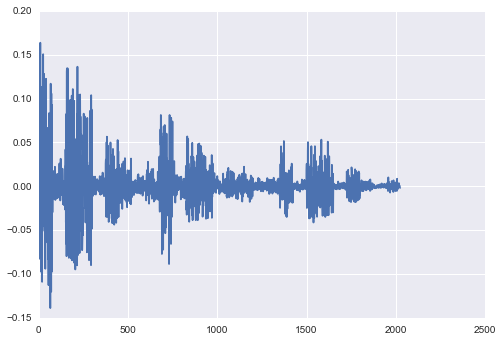

In [13]:
plt.plot(np.concatenate(pp_sig))

In [14]:
new_dm = np.concatenate(dm_train)
new_sig = np.concatenate(pp_sig)

In [15]:
X = new_dm[:n_split]
X_prime = new_dm[n_split:n_split*2]

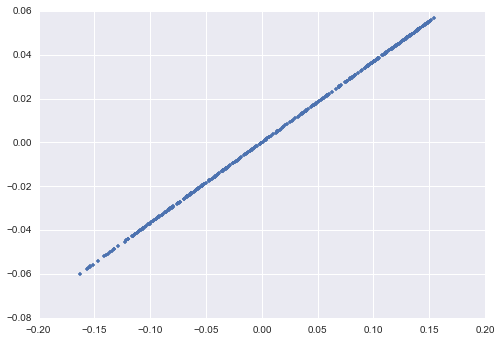

In [16]:
plt.plot(X[0], X_prime[0], '.')

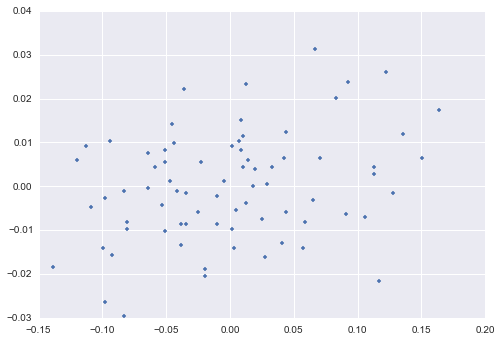

In [17]:
plt.plot(new_sig[:n_split], new_sig[n_split:n_split*2], '.')

In [18]:
from sklearn.linear_model import ElasticNet

In [19]:
this_alpha = alpha * np.sum(sq_weights)/new_dm.shape[0]
EN = ElasticNet(alpha=this_alpha, l1_ratio=l1_ratio, positive=True)
beta = EN.fit(new_dm, new_sig).coef_
#beta, rnorm = opt.nnls(new_dm, new_sig)

In [20]:
new_dm.shape, new_sig.shape

((2025, 362), (2025,))

In [21]:
y_hat = np.dot(new_dm, beta)

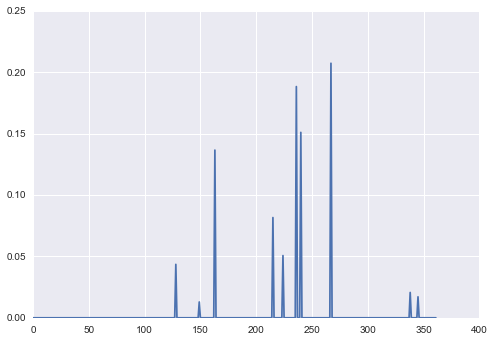

In [22]:
plt.plot(beta)

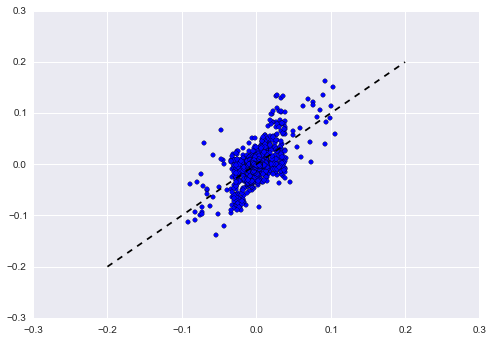

In [44]:
plt.scatter(y_hat, new_sig)
plt.plot([-0.2, 0.2], [-0.2, 0.2], 'k--')

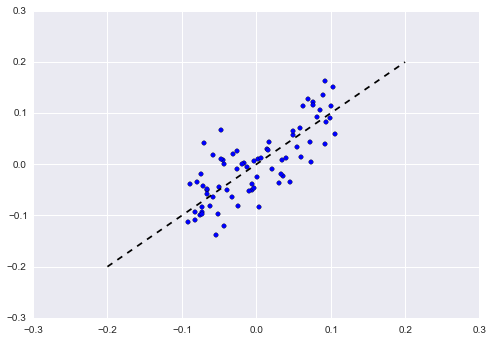

In [45]:
plt.scatter(y_hat[:n_split], new_sig[:n_split])
plt.plot([-0.2, 0.2], [-0.2, 0.2], 'k--')

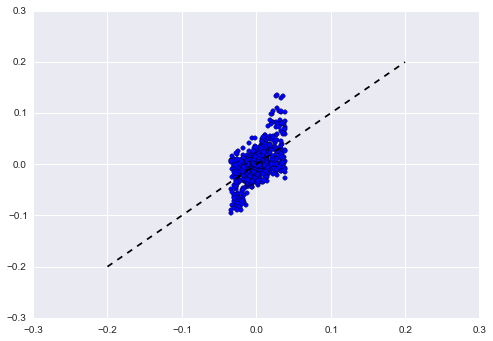

In [46]:
plt.scatter(y_hat[n_split:], new_sig[n_split:])
plt.plot([-0.2, 0.2], [-0.2, 0.2], 'k--')

In [26]:
#beta_non, rnorm = opt.nnls(new_dm[:n_split], new_sig[:n_split])
#beta_non, rnorm = opt.nnls(new_dm[:n_split], new_sig[:n_split])
EN = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, positive=True)
beta_non = EN.fit(new_dm[:n_split], new_sig[:n_split]).coef_


/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:490: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [47]:
y_hat_non = np.dot(new_dm, beta_non)

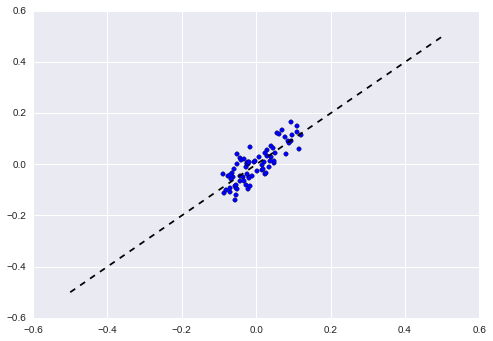

In [48]:
plt.scatter(y_hat_non[:n_split], new_sig[:n_split])
plt.plot([-0.5, 0.5], [-0.5, 0.5], 'k--')

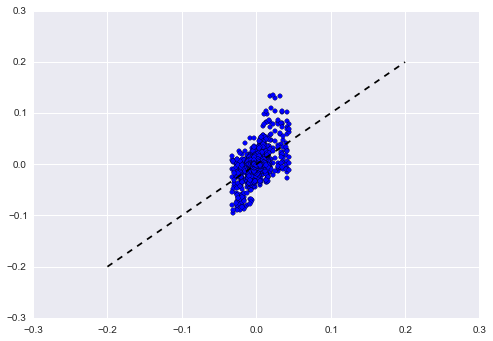

In [49]:
plt.scatter(y_hat_non[n_split:], new_sig[n_split:])
plt.plot([-0.2, 0.2], [-0.2, 0.2], 'k--')

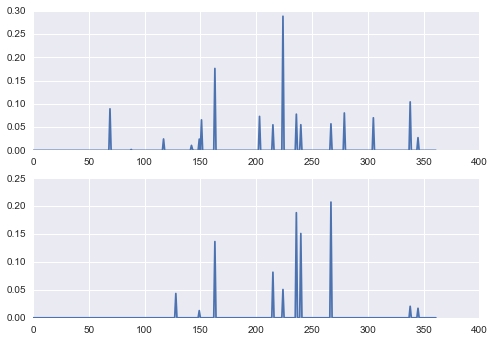

In [29]:
fig, ax = plt.subplots(2)
ax[0].plot(beta_non)
ax[1].plot(beta)

In [52]:
import dipy.viz.projections as proj
reload(proj)

<module 'dipy.viz.projections' from '/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/dipy/viz/projections.pyc'>

In [56]:
%matplotlib inline

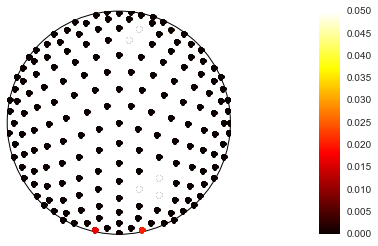

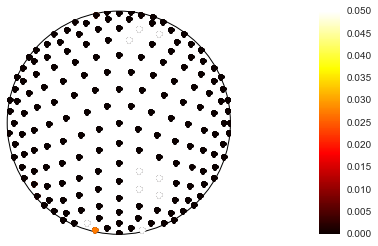

In [59]:
proj.sph_project(sph1.vertices.T, beta, vmax=0.05) 
proj.sph_project(sph1.vertices.T, beta_non, vmax=0.05) 


In [30]:
np.dot(beta_non, beta_non), np.dot(beta, beta)

(0.171575751397297, 0.13193850670939822)

In [31]:
(np.sqrt(np.mean( (y_hat_non[:n_split]- new_sig[:n_split]) ** 2))/
np.sqrt(np.mean( (new_sig[:n_split] - y_hat[:n_split])**2 ) ))

0.91458968973012678

In [32]:
dm_test = np.concatenate(ana.design_matrix(gtab_test, sph1))

In [33]:
y_hat_test = np.dot(dm_test, beta)
y_hat_non_test = np.dot(dm_test, beta_non)

In [34]:
sig_test, sq_weights_test = ana.preprocess_signal(data_test, gtab_train, 40, 40, 40)
sig_test = np.concatenate(sig_test)

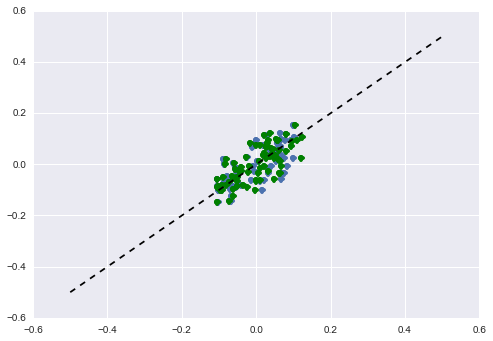

In [35]:
plt.plot(y_hat_test[:n_split], sig_test[:n_split], 'o')
plt.plot(y_hat_non_test[:n_split], sig_test[:n_split], 'go')
plt.plot([-0.5, 0.5], [-0.5, 0.5], 'k--')

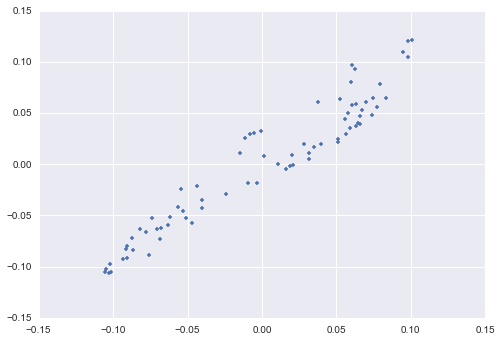

In [36]:
plt.plot(y_hat_test[:n_split], y_hat_non_test[:n_split], '.')

In [37]:
(np.sqrt(np.mean( (y_hat_non_test[:n_split]- sig_test[:n_split]) ** 2))/
np.sqrt(np.mean((sig_test[:n_split] - y_hat_test[:n_split])**2 )))

0.96152075810680793

In [38]:
import dipy.viz.fvtk as fvtk

In [39]:
def plot_peaks(beta, sphere, fname=None):
    idx = np.where(beta>0)
    peak_dirs = sphere.vertices[idx]
    peak_values = beta[idx]
    ren = fvtk.ren()
    beta_peaks = fvtk.peaks(peak_dirs, peak_values)
    fvtk.add(ren, beta_peaks)
    if fname is None:
        fvtk.show(ren)
    else:
        fvtk.record(ren, out_path=fname) 

In [40]:
#plot_peaks(beta, sph1, fname='./fig.png')
#!open fig.png